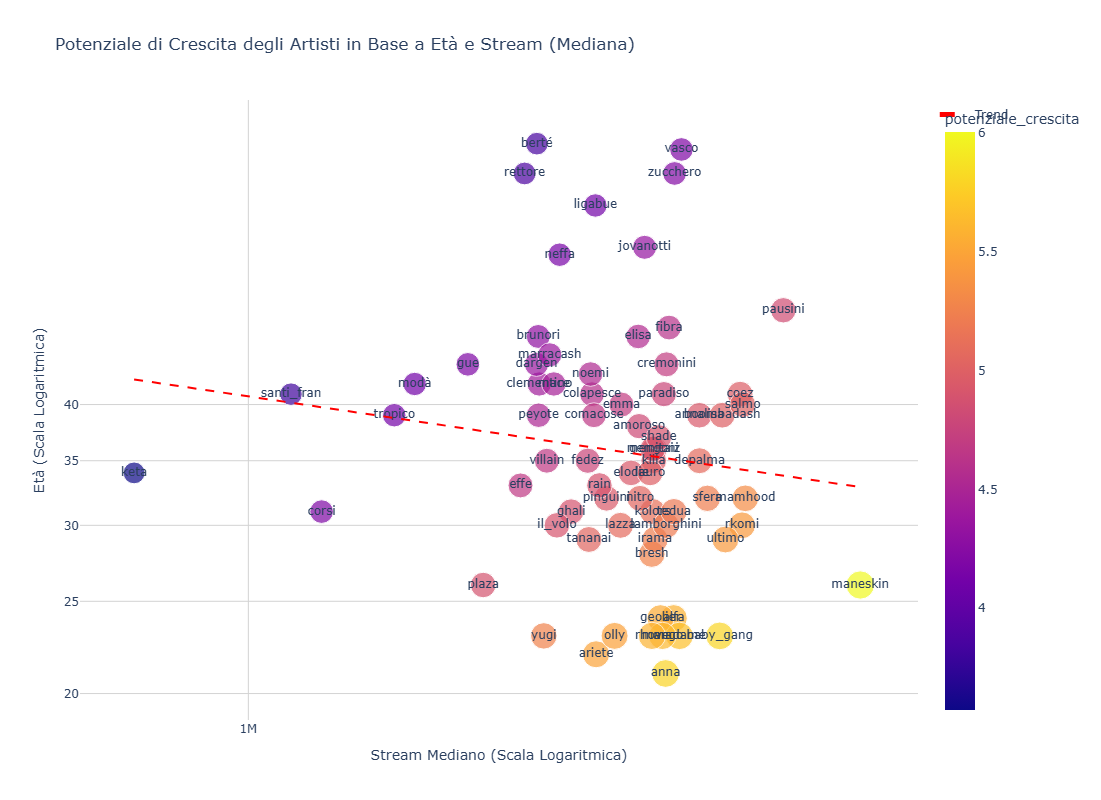

In [11]:
import numpy as np
import pandas as pd
import plotly.express as px

# Assumiamo che df sia già stato caricato e contenga 'NOME', 'ETA', 'STREAM'
# Filtriamo i dati per evitare problemi con valori nulli o negativi
df_filtered = df[(df['STREAM'] > 0) & (df['ETA'] > 0)].copy()

# Raggruppiamo per artista e calcoliamo la MEDIANA degli stream
df_grouped = df_filtered.groupby('NOME').agg(
    MEDIANA_STREAM=('STREAM', 'median'),  # Mediana degli stream per artista
    ETA=('ETA', 'first')  # Supponiamo che l'età sia uguale per tutte le tracce dell'artista
).reset_index()

# Applichiamo la trasformazione logaritmica
df_grouped['log_STREAM'] = np.log1p(df_grouped['MEDIANA_STREAM'])  
df_grouped['log_ETA'] = np.log1p(df_grouped['ETA'])  

# Calcoliamo il potenziale di crescita
df_grouped['potenziale_crescita'] = (1 / df_grouped['log_ETA']) * df_grouped['log_STREAM']

# Normalizziamo la dimensione delle bolle
df_grouped['size_scaled'] = df_grouped['potenziale_crescita'] / df_grouped['potenziale_crescita'].max() * 30

# Creiamo il grafico migliorato
fig = px.scatter(
    df_grouped, 
    x='log_STREAM', 
    y='log_ETA', 
    text='NOME',  
    title="Potenziale di Crescita degli Artisti in Base a Età e Stream (Mediana)", 
    labels={'log_STREAM': 'Log(Stream Mediano)', 'log_ETA': 'Log(Età)'}, 
    hover_name='NOME',  
    hover_data={'MEDIANA_STREAM': True, 'ETA': True, 'potenziale_crescita': True},  
    size='size_scaled',  # Bolle bilanciate
    color='potenziale_crescita',  
    color_continuous_scale='Plasma',  
)

# Miglioriamo il layout per chiarezza
fig.update_layout(
    xaxis=dict(
        title='Stream Mediano (Scala Logaritmica)',
        tickmode='array',
        tickvals=[np.log1p(val) for val in [1000, 10000, 100000, 1000000]],  
        ticktext=['1K', '10K', '100K', '1M'],  
        gridcolor='lightgray'  
    ),
    yaxis=dict(
        title='Età (Scala Logaritmica)',
        tickmode='array',
        tickvals=[np.log1p(val) for val in [18, 20, 25, 30, 35, 40]],  
        ticktext=['18', '20', '25', '30', '35', '40'],  
        gridcolor='lightgray'  
    ),
    autosize=False,
    width=1200,
    height=800,
    plot_bgcolor='white'
)

# Aggiungiamo una linea di tendenza per migliorare la leggibilità
import plotly.graph_objects as go
from numpy.polynomial.polynomial import Polynomial

# Regressione polinomiale per la tendenza
coefs = Polynomial.fit(df_grouped['log_STREAM'], df_grouped['log_ETA'], 1).convert().coef
trend_x = np.linspace(df_grouped['log_STREAM'].min(), df_grouped['log_STREAM'].max(), 100)
trend_y = coefs[0] + coefs[1] * trend_x

fig.add_trace(go.Scatter(
    x=trend_x, 
    y=trend_y, 
    mode='lines', 
    name='Trend',
    line=dict(color='red', width=2, dash='dash')
))

# Mostra il grafico
fig.show()




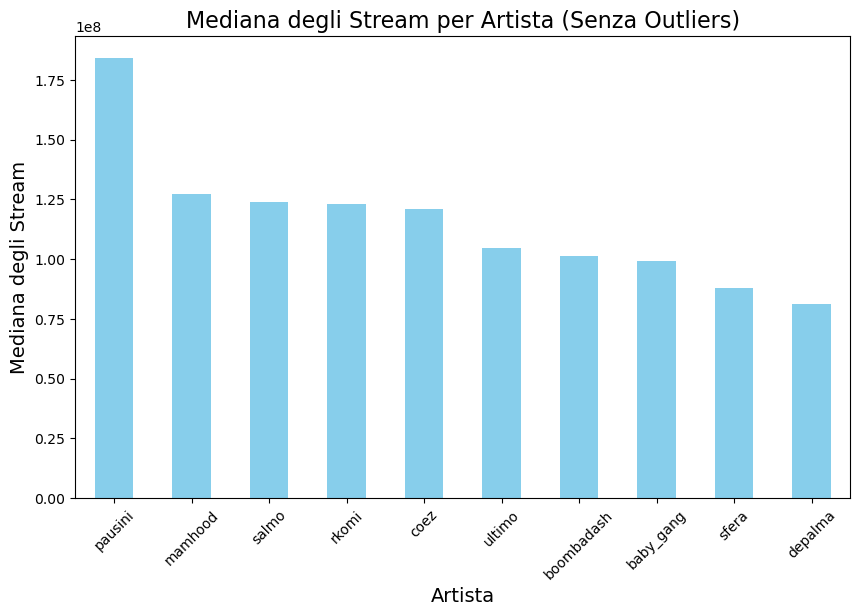

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Escludere i Maneskin
df_no_outliers = df[df['NOME'] != 'maneskin']

# Raggruppare per artista e calcolare la mediana degli stream
mediana_stream_no_outliers = df_no_outliers.groupby('NOME')['STREAM'].median().sort_values(ascending=False)

# Visualizzare il grafico senza i Maneskin
plt.figure(figsize=(10, 6))
mediana_stream_no_outliers.head(10).plot(kind='bar', color='skyblue')

# Aggiungere un titolo e le etichette
plt.title('Mediana degli Stream per Artista (Senza Outliers)', fontsize=16)
plt.xlabel('Artista', fontsize=14)
plt.ylabel('Mediana degli Stream', fontsize=14)

# Mostrare il grafico
plt.xticks(rotation=45)
plt.show()



Correlazione tra età e streams: -0.15265596914228297


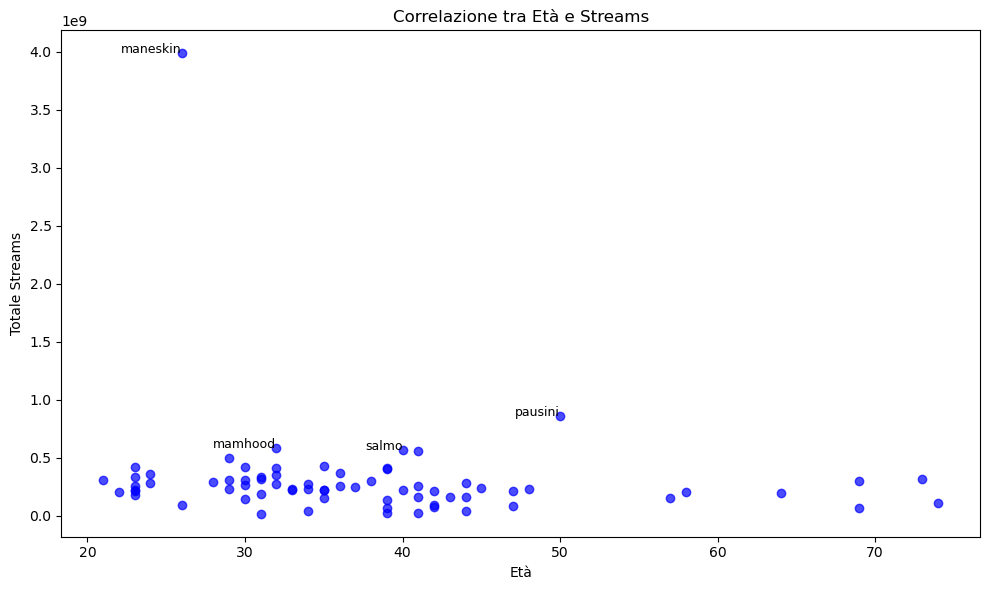

In [16]:
# Calcoliamo la somma totale degli stream per ogni artista
df['TOTAL_STREAMS'] = df.groupby('NOME')['STREAM'].transform('sum')

# Raggruppiamo per artista per ottenere anche l'età
df_grouped = df.drop_duplicates(subset=['NOME'])[['NOME', 'ETA', 'TOTAL_STREAMS']]

# Calcoliamo la correlazione tra età e streams
correlation = df_grouped['ETA'].corr(df_grouped['TOTAL_STREAMS'])
print(f"Correlazione tra età e streams: {correlation}")

# Creiamo un grafico scatter
plt.figure(figsize=(10, 6))
plt.scatter(df_grouped['ETA'], df_grouped['TOTAL_STREAMS'], color='blue', alpha=0.7)

# Aggiungiamo i nomi degli artisti solo per quelli con stream più alti di una certa soglia
threshold = df_grouped['TOTAL_STREAMS'].quantile(0.95)  # Prendiamo il 75° percentile come soglia
for i in range(df_grouped.shape[0]):
    if df_grouped['TOTAL_STREAMS'].iloc[i] > threshold:
        plt.text(df_grouped['ETA'].iloc[i], df_grouped['TOTAL_STREAMS'].iloc[i], 
                 df_grouped['NOME'].iloc[i], fontsize=9, ha='right')

plt.title('Correlazione tra Età e Streams')
plt.xlabel('Età')
plt.ylabel('Totale Streams')
plt.tight_layout()  # Per evitare che i nomi degli artisti vengano tagliati
plt.show()

In [20]:
# Aggiungi una nuova colonna 'guadagno' che calcola il guadagno per ogni brano in base agli stream
# 0.004 euro è il guadagno per stream (in eurocent)
df['guadagno'] = df['STREAM'] * 0.004

# Calcolare il guadagno medio per ogni artista
# Gruppo per artista (colonna 'NOME') e calcolo la media dei guadagni
guadagno_medio_per_artista = df.groupby('NOME')['guadagno'].mean()

# Ordinare i guadagni in ordine decrescente
guadagno_medio_per_artista = guadagno_medio_per_artista.sort_values(ascending=False)

# Riformattare i guadagni medi per artista in formato Euro con 2 decimali
# La funzione 'apply' serve per formattare ogni valore come una stringa con simbolo Euro
guadagno_medio_per_artista_in_euro = guadagno_medio_per_artista.apply(lambda x: f'€{x:,.2f}')

# Visualizzare il guadagno medio per artista in ordine decrescente
print(guadagno_medio_per_artista_in_euro)

NOME
maneskin      €3,189,457.91
pausini         €684,768.46
mamhood         €469,700.19
salmo           €451,466.22
coez            €448,681.78
                  ...      
gue              €34,853.43
keta             €31,435.37
tropico          €18,361.05
santi_fran       €16,805.81
corsi            €14,167.33
Name: guadagno, Length: 71, dtype: object


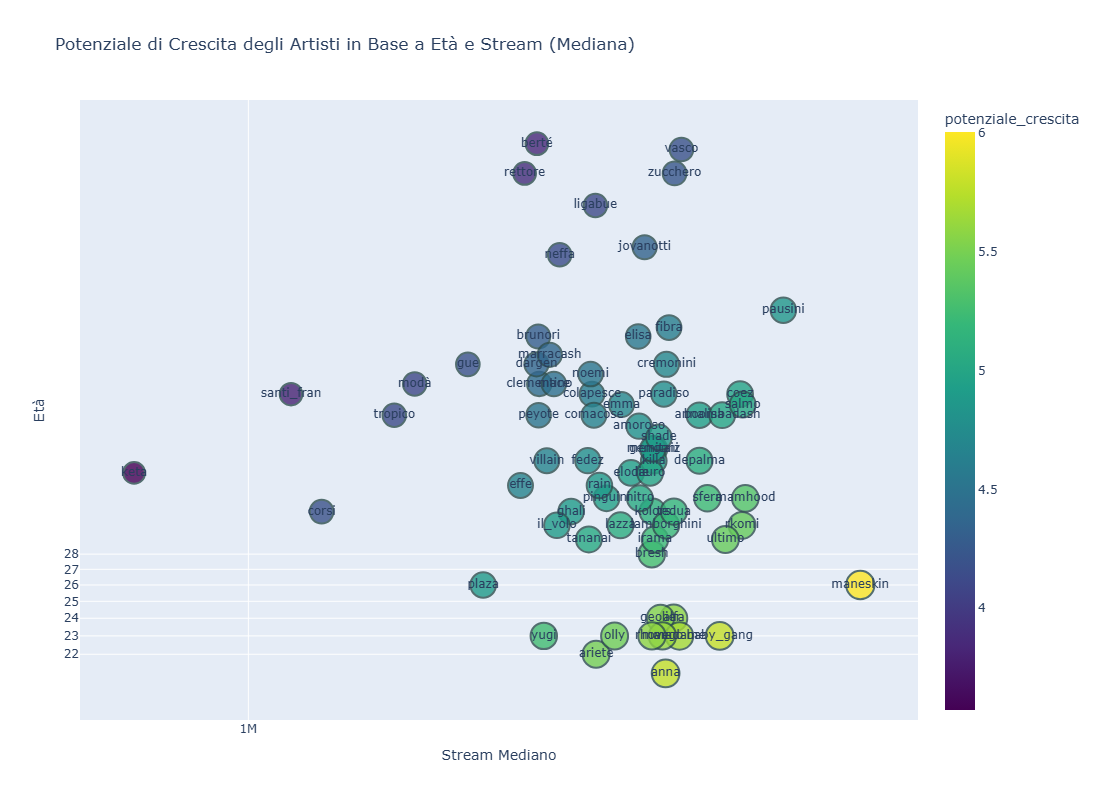

In [23]:
import numpy as np
import pandas as pd
import plotly.express as px

# Assumiamo che df sia già stato caricato e contenga 'NOME', 'ETA', 'STREAM'

# Filtriamo i dati per evitare problemi con valori nulli o negativi
df_filtered = df[(df['STREAM'] > 0) & (df['ETA'] > 0)].copy()

# Raggruppiamo per artista e calcoliamo la MEDIANA degli stream (non più la media)
df_grouped = df_filtered.groupby('NOME').agg(
    MEDIANA_STREAM=('STREAM', 'median'),  # Calcoliamo la mediana degli stream per ogni artista
    ETA=('ETA', 'first')  # Supponiamo che l'età sia la stessa per tutte le tracce di ogni artista
).reset_index()

# Applichiamo la trasformazione logaritmica sugli stream e sull'età
df_grouped['log_STREAM'] = np.log1p(df_grouped['MEDIANA_STREAM'])  # log1p è log(x+1), utile per evitare log(0)
df_grouped['log_ETA'] = np.log1p(df_grouped['ETA'])  # logaritmo sull'età (log(x+1))

# Nuova metrica di potenziale di crescita con dati logaritmici
df_grouped['potenziale_crescita'] = (1 / df_grouped['log_ETA']) * df_grouped['log_STREAM']

# Creiamo il grafico con i nuovi dati logaritmici
fig = px.scatter(df_grouped, 
                 x='log_STREAM', 
                 y='log_ETA', 
                 text='NOME',  # Mostra il nome al passaggio del mouse
                 title="Potenziale di Crescita degli Artisti in Base a Età e Stream (Mediana)", 
                 labels={'log_STREAM': 'Log(Stream Mediano)', 'log_ETA': 'Log(Età)'}, 
                 hover_name='NOME',  # Quando il mouse è sopra, mostriamo il nome
                 hover_data={'log_STREAM': True, 'log_ETA': True, 'potenziale_crescita': True},  # Aggiungiamo il punteggio di crescita
                 size='potenziale_crescita',  # La dimensione dei cerchi rappresenta il punteggio di crescita
                 color='potenziale_crescita',  # Coloriamo i punti in base al punteggio di crescita
                 color_continuous_scale='Viridis',  # Una scala di colori che va dal basso all'alto
                 )

# Aggiustiamo la dimensione dei marker e l'opacità
fig.update_traces(marker=dict(opacity=0.8, line=dict(width=2, color='DarkSlateGrey')),
                  selector=dict(mode='markers+text'))

# Formattiamo l'asse X (stream) per visualizzare in migliaia (K)
fig.update_layout(
    xaxis=dict(
        title='Stream Mediano',
        tickmode='array',
        tickvals=[np.log1p(val) for val in [1000, 10000, 100000, 1000000]],  # Valori da visualizzare in scala logaritmica
        ticktext=['1K', '10K', '100K', '1M'],  # Etichette
    ),
    yaxis=dict(
        title='Età',
        tickmode='array',
        tickvals=[np.log1p(val) for val in [22, 23, 24, 25, 26, 27, 28]],  # Esempio di età
        ticktext=['22', '23', '24', '25', '26', '27', '28'],  # Etichette dell'età
    ),
    autosize=False,
    width=1200,  # Aumentiamo la larghezza del grafico
    height=800,  # Aumentiamo l'altezza del grafico
)

# Mostra il grafico
fig.show()


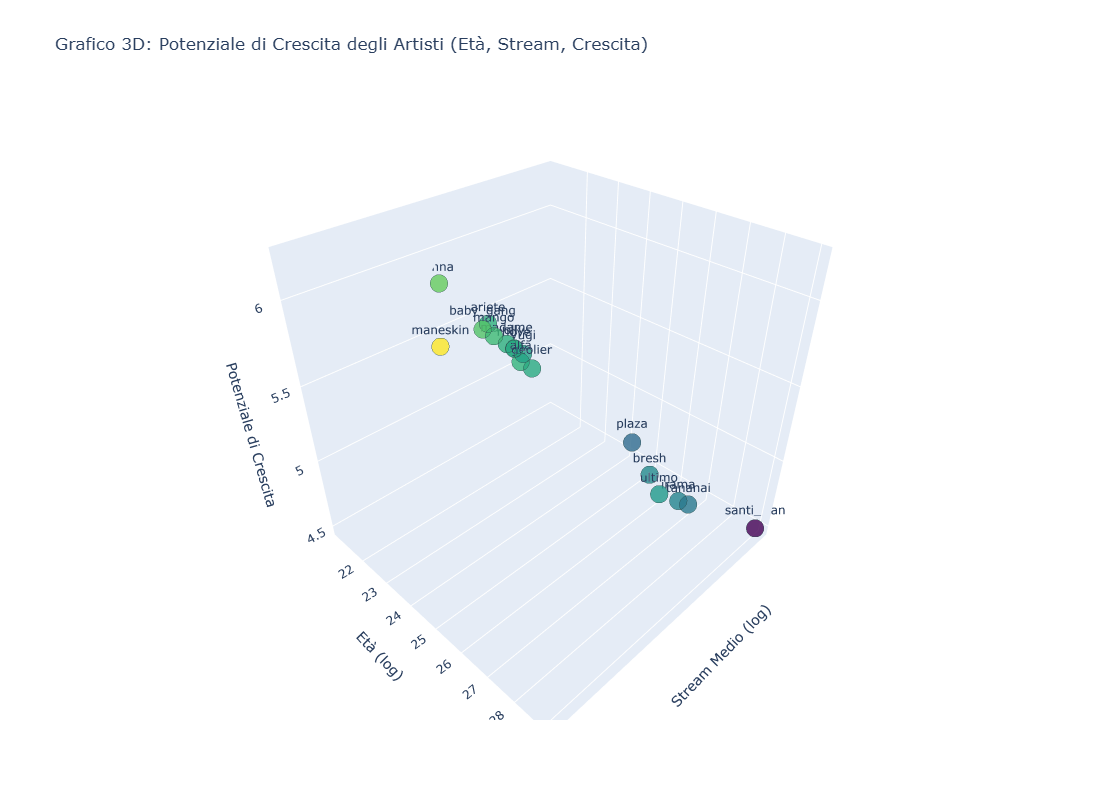

In [21]:
# Raggruppiamo per ARTISTA e calcoliamo la media degli STREAM per ciascun artista
df_artist = df.groupby('NOME').agg(
    STREAM=('STREAM', 'mean'),
    ETA=('ETA', 'mean')
).reset_index()

# Filtriamo gli artisti con età maggiore di 29 anni
df_artist = df_artist[df_artist['ETA'] <= 29]

# Aggiungiamo la trasformazione logaritmica sugli stream e sull'età
df_artist['log_STREAM'] = np.log1p(df_artist['STREAM'])  # log(x+1) sugli stream
df_artist['log_ETA'] = np.log1p(df_artist['ETA'])  # log(x+1) sull'età

# Nuova metrica di potenziale di crescita (più è giovane, più alto è il potenziale)
df_artist['potenziale_crescita'] = (1 / df_artist['log_ETA']) * df_artist['log_STREAM']

# Creiamo il grafico 3D
fig = go.Figure(data=[go.Scatter3d(
    x=df_artist['log_STREAM'],  # log(Stream Medio) sull'asse X
    y=df_artist['log_ETA'],     # log(Età) sull'asse Y
    z=df_artist['potenziale_crescita'],  # Potenziale di crescita sull'asse Z
    mode='markers+text',
    text=df_artist['NOME'],  # Mostriamo il nome al passaggio del mouse
    marker=dict(
        size=10,
        opacity=0.8,
        color=df_artist['potenziale_crescita'],  # Coloriamo i punti in base al potenziale di crescita
        colorscale='Viridis',  # Scala di colori dal basso all'alto
        line=dict(width=2, color='DarkSlateGrey')  # Bordo dei marker
    )
)])

# Aggiungiamo etichette e titoli
fig.update_layout(
    scene=dict(
        xaxis_title='Stream Medio (log)',
        yaxis_title='Età (log)',
        zaxis_title='Potenziale di Crescita',
        xaxis=dict(tickvals=[np.log1p(val) for val in [1000, 10000, 100000, 1000000]], ticktext=['1K', '10K', '100K', '1M']),
        yaxis=dict(tickvals=[np.log1p(val) for val in [22, 23, 24, 25, 26, 27, 28, 29]], ticktext=['22', '23', '24', '25', '26', '27', '28', '29'])
    ),
    title="Grafico 3D: Potenziale di Crescita degli Artisti (Età, Stream, Crescita)",
    autosize=True,
    width=1200,  # Larghezza
    height=800,  # Altezza
)

# Mostra il grafico
fig.show()


